# 🧠 Shadow PM Project: Duolingo Retention & Feature Analysis (Expanded)

This notebook simulates being a Product Manager for Duolingo. We'll analyze user behavior and feature usage to find patterns, segment users, and propose feature-level A/B tests and product improvements.

## Step 1: Load CSV Data

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSVs (after uploading to Colab)
user_behavior = pd.read_csv("user_behavior_simulated.csv")
feature_events = pd.read_csv("feature_events_simulated.csv")

user_behavior['features_used_list'] = user_behavior['features_used'].apply(lambda x: x.split(', '))
user_behavior.head()


,user_id,signup_date,total_sessions,avg_session_length,features_used,streak_days,paid_user,churned,features_used_list
0,1,2024-03-22,122,13.43,Daily XP,0,1,0,[Daily XP]
1,2,2024-01-15,199,15.91,Leaderboard,47,0,0,[Leaderboard]
2,3,2024-01-04,112,12.63,"Leaderboard, Stories",11,1,0,"[Leaderboard, Stories]"
3,4,2024-02-05,34,13.79,Achievements,4,1,0,[Achievements]
4,5,2024-02-01,126,9.31,"Leaderboard, Daily XP, Achievements",36,1,0,"[Leaderboard, Daily XP, Achievements]"


## Step 2: Analyze Overall Feature Usage

In [2]:

from collections import Counter
from itertools import chain

flat_features = list(chain.from_iterable(user_behavior['features_used_list']))
feature_counts = Counter(flat_features)

pd.DataFrame(feature_counts.items(), columns=['Feature', 'User Count']).sort_values(by='User Count', ascending=False)


,Feature,User Count
0,Daily XP,44
1,Leaderboard,41
2,Stories,38
3,Achievements,38
4,Grammar Tips,35


## Step 3: Visualize Streak Days vs Churn

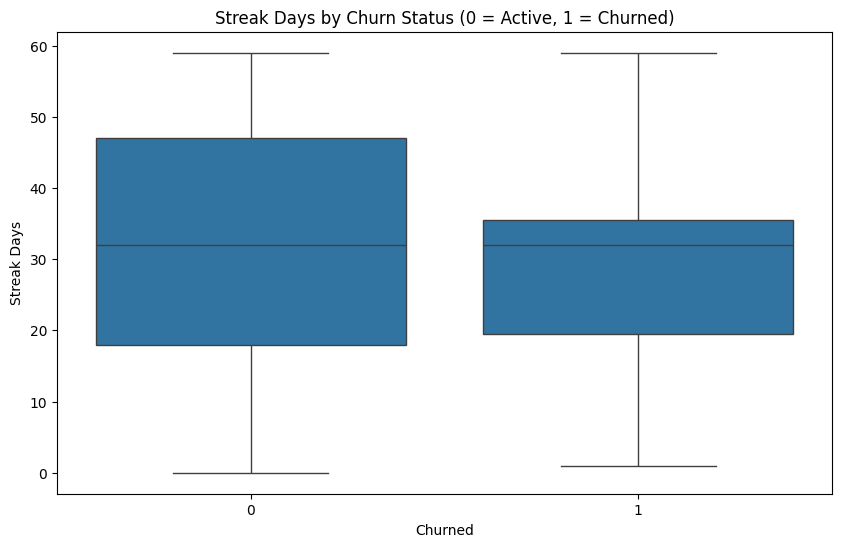

In [3]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=user_behavior, x='churned', y='streak_days')
plt.title('Streak Days by Churn Status (0 = Active, 1 = Churned)')
plt.xlabel('Churned')
plt.ylabel('Streak Days')
plt.show()


## Step 4: Segment Users by Behavior

In [4]:

def segment_user(row):
    if row['total_sessions'] > 120 and row['streak_days'] > 30:
        return 'Power User'
    elif row['total_sessions'] < 50 and row['churned'] == 1:
        return 'At-Risk'
    else:
        return 'Casual'

user_behavior['segment'] = user_behavior.apply(segment_user, axis=1)
user_behavior['segment'].value_counts()


,count
segment,
Casual,70
Power User,22
At-Risk,8


## Step 5: Compare Feature Usage by Segment

In [5]:

import numpy as np

segment_features = {}
for segment in user_behavior['segment'].unique():
    users = user_behavior[user_behavior['segment'] == segment]
    all_feats = list(chain.from_iterable(users['features_used_list']))
    counts = Counter(all_feats)
    segment_features[segment] = counts

pd.DataFrame(segment_features).fillna(0).astype(int)


,Casual,Power User,At-Risk
Daily XP,30,10,4
Leaderboard,29,9,3
Stories,29,6,3
Achievements,30,6,2
Grammar Tips,23,10,2


## Step 6: Analyze Avg Time Spent per Feature

In [6]:

feature_time = feature_events.groupby('feature_name')['time_spent_sec'].mean().reset_index().sort_values(by='time_spent_sec', ascending=False)
feature_time


,feature_name,time_spent_sec
2,Grammar Tips,158.753769
4,Stories,153.441176
1,Daily XP,149.678788
3,Leaderboard,146.634921
0,Achievements,143.052632


## Step 7: Churn Rate by Feature

In [11]:
flat_features = list(chain.from_iterable(user_behavior['features_used_list']))
unique_features = list(set(flat_features))

feature_churn = []

for feature in unique_features:
    has_feature = user_behavior[user_behavior['features_used'].str.contains(feature)]
    churn_rate = has_feature['churned'].mean()
    feature_churn.append((feature, churn_rate))

feature_churn_df = pd.DataFrame(feature_churn, columns=['Feature', 'Churn Rate'])
feature_churn_df.sort_values(by='Churn Rate')


,Feature,Churn Rate
4,Stories,0.184211
1,Leaderboard,0.195122
0,Achievements,0.289474
2,Grammar Tips,0.342857
3,Daily XP,0.386364


## 💡 Step 8: Product Recommendations & A/B Tests

- Promote **Streak** features earlier in onboarding
- Prioritize development on **Stories** and **Daily XP** based on time spent and low churn correlation
- Consider A/B testing:
  - New user onboarding with/without 'Leaderboard'
  - A personalized dashboard for Power Users
- Consider gating features with highest time spent for upselling in freemium model